In [65]:
import xgboost as xgb
import scipy.sparse
import pandas as pd

# Load the preprocessed sparse data
X_test = scipy.sparse.load_npz('./preprocessed_data/X_test_sparse.npz')
y_test = pd.read_csv('./preprocessed_data/test_labels.csv')

# Load the pretrained XGBoost model
bst = xgb.Booster()
bst.load_model('xgboost_model.json')

# Convert the test data into DMatrix format (required by XGBoost)
dtest = xgb.DMatrix(X_test)

# Make predictions using the loaded model
y_pred_prob = bst.predict(dtest)
y_pred = (y_pred_prob > 0.5).astype(int)

# Optionally, evaluate the model's performance if you have the true labels
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.95      0.97      0.96    398074
           1       0.88      0.79      0.84     96082

    accuracy                           0.94    494156
   macro avg       0.92      0.88      0.90    494156
weighted avg       0.94      0.94      0.94    494156

Confusion Matrix:
 [[388044  10030]
 [ 19779  76303]]


In [66]:
column_names = ['target', 'id', 'date', 'flag', 'user', 'text']

df = pd.read_csv('./Datasets/training.1600000.processed.noemoticon.csv', encoding='latin-1', names=column_names)

df.info()

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   id      1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


In [67]:
df['target'] = df['target'].map({0: 1, 4: 0, 2: 0})

In [68]:
import re

# Text cleaning function
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove user mentions and hashtags
    text = re.sub(r'\@\w+|\#', '', text)
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    # Lowercase the text
    text = text.lower()
    return text

# Apply the text cleaning function
df['cleaned_text'] = df['text'].apply(clean_text)

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming 'vectorizer' was saved from the Reddit data preprocessing, load it
# For demonstration, let's say it was saved as 'tfidf_vectorizer.pkl'

import joblib
vectorizer = joblib.load('./preprocessed_data/tfidf_vectorizer.pkl')

# Transform the Twitter data text into TF-IDF features
X_twitter = vectorizer.transform(df['cleaned_text'])

In [70]:
# Make predictions on the Twitter dataset
y_twitter_pred = bst.predict(xgb.DMatrix(X_twitter))
y_twitter_pred_labels = [1 if pred > 0.5 else 0 for pred in y_twitter_pred]

# Add the predicted labels to the DataFrame
df['predicted_sentiment'] = y_twitter_pred_labels


In [71]:
# Filter for tweets classified as depressive
depressive_tweets = df[df['predicted_sentiment'] == 1]

# Display sample depressive tweets
depressive_tweets[['text', 'predicted_sentiment']].head()

,text,predicted_sentiment
234,@ircmaxell - I think I need to find better anti-depressants. I think this Paxil/Wellbutrin combo is losing its efficacy.,1
287,feels like she slept the day away. Not looking forward to any more bouts with my gallbladder. At least I have pills now for the pain.,1
341,@hyperbets i hope this doesn't last too long. i feel miserable!,1
732,im so tired of work...i need a life....,1
1408,"@RedGray Ah man- so sad, his cousin committed suicide yest and she was 8 months pregnant - can you imagine... we been crying non stop...",1


In [72]:
depressive_tweets.count()

target                 2852
id                     2852
date                   2852
flag                   2852
user                   2852
text                   2852
cleaned_text           2852
predicted_sentiment    2852
dtype: int64

In [73]:
depressive_tweets[['text', 'predicted_sentiment']].tail()

,text,predicted_sentiment
1585775,"God I would kill to be going to transformers 2 tonight, so anyone going steer clear of me",1
1589685,@prissyharajuku:i hope so too! i wish i had someone to wake up to lls! awww.,1
1590835,"@kemalispirli I feel what you feel, we have been living with PC for years But, there is a good point and it is called &quot;Red Alert 3&quot;",1
1594284,@AlWoods Nice. It always feels good. We don't want to get like Seattle. That's depressing. They have suicide kits in their Happy Meals,1
1594340,"@shellisxena HI Shelley, it's nice to meet you I live in Meridian, ID. was last in Portland for seminar on treating depression naturally",1


In [74]:
# Set display option to show the full text
pd.set_option('display.max_colwidth', None)

# See the texts for depressive tweets under specified indices in bulk
#indices = [234, 287, 341, 732, 1408, 1585775, 1589685, 1590835, 1594284, 1594340]
depressive_tweets.loc[234]


target                                                                                                                                           1
id                                                                                                                                      1467872309
date                                                                                                                  Mon Apr 06 22:35:51 PDT 2009
flag                                                                                                                                      NO_QUERY
user                                                                                                                                         dossy
text                   @ircmaxell - I think I need to find better anti-depressants.  I think this Paxil/Wellbutrin combo is losing its efficacy.  
cleaned_text                            i think i need to find better antidepressants  i think this paxilwellbutrin co

In [75]:
# Convert the date column to datetime format
df['date'] = pd.to_datetime(df['date'])

C:\Users\shaun\AppData\Local\Temp\ipykernel_10716\1573547618.py:2: FutureWarning: Parsed string "Mon Apr 06 22:19:45 PDT 2009" included an un-recognized timezone "PDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df['date'] = pd.to_datetime(df['date'])


In [76]:
df.head()

,target,id,date,flag,user,text,cleaned_text,predicted_sentiment
0,1,1467810369,2009-04-06 22:19:45,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",a thats a bummer you shoulda got david carr of third day to do it d,0
1,1,1467810672,2009-04-06 22:19:49,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,is upset that he cant update his facebook by texting it and might cry as a result school today also blah,0
2,1,1467810917,2009-04-06 22:19:53,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,i dived many times for the ball managed to save 50 the rest go out of bounds,0
3,1,1467811184,2009-04-06 22:19:57,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,0
4,1,1467811193,2009-04-06 22:19:57,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",no its not behaving at all im mad why am i here because i cant see you all over there,0


In [77]:
depressive_tweets['date'] = pd.to_datetime(depressive_tweets['date'])
depressive_tweets.head()

C:\Users\shaun\AppData\Local\Temp\ipykernel_10716\910384950.py:1: FutureWarning: Parsed string "Mon Apr 06 22:35:51 PDT 2009" included an un-recognized timezone "PDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  depressive_tweets['date'] = pd.to_datetime(depressive_tweets['date'])
C:\Users\shaun\AppData\Local\Temp\ipykernel_10716\910384950.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  depressive_tweets['date'] = pd.to_datetime(depressive_tweets['date'])


,target,id,date,flag,user,text,cleaned_text,predicted_sentiment
234,1,1467872309,2009-04-06 22:35:51,NO_QUERY,dossy,@ircmaxell - I think I need to find better anti-depressants. I think this Paxil/Wellbutrin combo is losing its efficacy.,i think i need to find better antidepressants i think this paxilwellbutrin combo is losing its efficacy,1
287,1,1467882140,2009-04-06 22:38:32,NO_QUERY,nyracat,feels like she slept the day away. Not looking forward to any more bouts with my gallbladder. At least I have pills now for the pain.,feels like she slept the day away not looking forward to any more bouts with my gallbladder at least i have pills now for the pain,1
341,1,1467897316,2009-04-06 22:42:37,NO_QUERY,nicolegreen,@hyperbets i hope this doesn't last too long. i feel miserable!,i hope this doesnt last too long i feel miserable,1
732,1,1467994306,2009-04-06 23:10:03,NO_QUERY,katiehufford,im so tired of work...i need a life....,im so tired of worki need a life,1
1408,1,1468147058,2009-04-06 23:58:34,NO_QUERY,KristySS,"@RedGray Ah man- so sad, his cousin committed suicide yest and she was 8 months pregnant - can you imagine... we been crying non stop...",ah man so sad his cousin committed suicide yest and she was 8 months pregnant can you imagine we been crying non stop,1


In [78]:
# Group by date and count the number of depressive tweets per day
depressive_tweet_counts = depressive_tweets.groupby(depressive_tweets['date'].dt.date).size()

In [79]:
# Create a DataFrame with dates and counts
depressive_tweet_counts_df = depressive_tweet_counts.reset_index(name='count')
depressive_tweet_counts_df.columns = ['date', 'depressive_tweet_count']

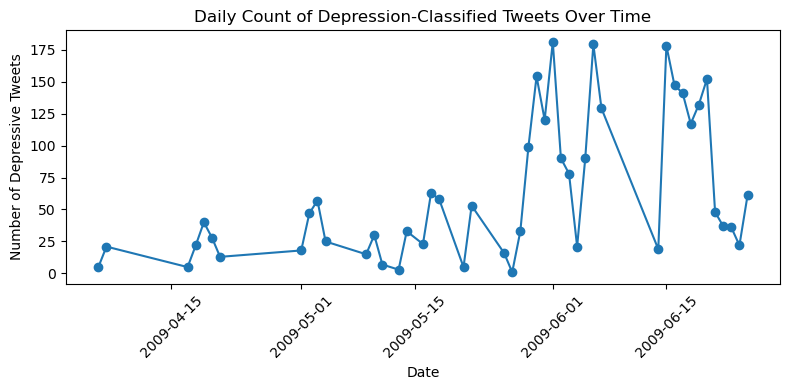

In [80]:
import matplotlib.pyplot as plt

# Plot the time series
plt.figure(figsize=(8, 4))
plt.plot(depressive_tweet_counts_df['date'], depressive_tweet_counts_df['depressive_tweet_count'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Number of Depressive Tweets')
plt.title('Daily Count of Depression-Classified Tweets Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [81]:
# Find the date with the highest number of depressive tweets
peak_date = depressive_tweet_counts_df.loc[depressive_tweet_counts_df['depressive_tweet_count'].idxmax(), 'date']
print("Peak date:", peak_date)

Peak date: 2009-06-01


In [82]:
# Filter for depressive tweets around the peak date (e.g., June 10, 2009)
peak_period_tweets = df[(df['date'] >= pd.to_datetime('2009-05-31')) & 
                        (df['date'] <= pd.to_datetime('2009-06-2')) & 
                        (df['predicted_sentiment'] == 1)]

In [83]:
peak_period_tweets[['date', 'text', 'predicted_sentiment']].head()


,date,text,predicted_sentiment
230122,2009-05-31 00:04:30,"@chr1zzy: aww ....It was good to see you tonight, feel better.",1
230428,2009-05-31 00:17:13,I'm going to sleep... I feel like I'm getting sicker ass the days go on! Wth thought it's suppose to get better! Sigh... I miss twin,1
231089,2009-05-31 00:48:54,"Ok, I feel retarded...how can I leave a Skype voicemail, or does it have to be a call? I read how somewhere but can't find it again tired",1
231091,2009-05-31 00:48:57,I now understand why people choose to run away. Why they choose to be homeless. And why they choose to commit suicide...,1
232914,2009-05-31 02:18:04,@FrankieTheSats aw I hope he gets better soon! xxx,1


In [84]:
from sklearn.feature_extraction.text import CountVectorizer

# Vectorize to get word counts
vectorizer = CountVectorizer(stop_words='english', max_features=20)
peak_text_counts = vectorizer.fit_transform(peak_period_tweets['text'])

# Sum counts for each word
word_counts = peak_text_counts.sum(axis=0)
word_freq = [(word, word_counts[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)

print("Top words in depressive tweets during peak period:", word_freq)

Top words in depressive tweets during peak period: [('feel', 138), ('better', 84), ('just', 74), ('hope', 71), ('life', 49), ('soon', 45), ('wish', 45), ('tired', 43), ('tonight', 36), ('want', 36), ('work', 33), ('feeling', 29), ('anymore', 28), ('don', 27), ('like', 26), ('really', 25), ('sorry', 25), ('need', 24), ('hate', 23), ('today', 21)]


In [85]:
from sklearn.decomposition import LatentDirichletAllocation

# Use the CountVectorizer output for topic modeling
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(peak_text_counts)

# Print the top words for each topic
for i, topic in enumerate(lda.components_):
    top_words = [vectorizer.get_feature_names_out()[index] for index in topic.argsort()[-10:]]
    print(f"Topic {i+1}: {', '.join(top_words)}")

Topic 1: tired, soon, don, really, today, feeling, just, hate, wish, life
Topic 2: soon, feeling, sorry, feel, really, don, just, anymore, tired, want
Topic 3: hate, today, don, really, feeling, sorry, soon, hope, feel, better
Topic 4: life, tired, really, work, hate, don, just, today, like, feel
Topic 5: better, hope, soon, feeling, really, tired, need, just, work, tonight


In [86]:
# Extract top words for each topic
topic_words = []
for topic in lda.components_:
    top_words = [vectorizer.get_feature_names_out()[index] for index in topic.argsort()[-10:]]
    topic_words.append(top_words)

# Sample tweets from each topic (e.g., top 5 tweets per topic)
for topic_num in range(5):
    print(f"\nTopic {topic_num + 1} Sample Tweets:")
    topic_tweets = peak_period_tweets[peak_period_tweets['text'].apply(lambda x: any(word in x for word in topic_words[topic_num]))]
    print(topic_tweets['text'].sample(5, random_state=42))


Topic 1 Sample Tweets:
237616     I love That Im Scottish But i hate Me i just feel that sometimes Im worthless and i guess today is one of those days  Ugh
1243601                                                           @Rosellyanna ooo right...well I hope it gets better soon  chin up 
269607                   Pointless exam time. Why did I bother? Having reallly stupid dreams latelyyy, I just want my friend backk. 
1233664                                     @GordonMJ I hope your feet feel better. At least you're not covered in garbage anymore. 
293229                                                                                 i am going to die i wish i had a boyfriend!! 
Name: text, dtype: object

Topic 2 Sample Tweets:
242551    @planethealer I have been living with severe pain recently and undergoing tests, Life is hard, but I don't want the alternative. 
233070                                                           I'm so tired ryu nice try today  I feel tired even lying

In [87]:
# Example keyword frequency comparison
h1n1_keywords = ['flu', 'virus', 'pandemic']
depressive_tweets['is_h1n1_related'] = depressive_tweets['text'].apply(lambda x: any(word in x for word in h1n1_keywords))

# Set the index to the date column for resampling
depressive_tweets.set_index('date', inplace=True)

# Resample and count the number of H1N1 related tweets per day
h1n1_related_counts = depressive_tweets[depressive_tweets['is_h1n1_related']].resample('D').size()


C:\Users\shaun\AppData\Local\Temp\ipykernel_10716\4030948262.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  depressive_tweets['is_h1n1_related'] = depressive_tweets['text'].apply(lambda x: any(word in x for word in h1n1_keywords))


In [88]:
# Filter for H1N1 related tweets
h1n1_related_tweets = depressive_tweets[depressive_tweets['is_h1n1_related']]

# Display the H1N1 related tweets
h1n1_related_tweets[['text', 'is_h1n1_related']].head()

,text,is_h1n1_related
date,,
2009-06-01 11:54:36,@grantswilson Feel better soon Grant! There are some ugly virus things going around. We had one cycling through our family for 2 weeks,True
2009-06-02 00:45:52,"I'm exhausted and I don't feel good. I can't handle another bout of the 'flu, please go away!!",True
2009-06-06 08:59:18,"I might have the swine flu, so I'm just going to lay in bed all day. I feel terrible. Bye bye Internet (for the day)",True
2009-06-18 23:43:16,Going to bed! it was a long day but im just glad i dont got dat swine flu. i WISH i couldve gone to razmataz,True
2009-06-25 01:49:50,"@supercopygurl lol heavy night I wish - no, woke up with full on flu super-grumpy but getting meds today so I can kill it quick!",True
